# Actor-Critic Methods

**Overview**:
In this practical we will train an agent using the Actor-Critic algorithm to learn to balance a pole in the OpenAI gym [Cartpole environment](https://gym.openai.com/envs/CartPole-v1).

**Learning objectives**:
* Understand the Actor-Critic approach to directly training a parameterised policy and state-value function to maximise expected future rewards.

**What is expected of you**:
 * Go through the explanation, keeping the above learning objectives in mind.
 * Fill in the missing code ("#IMPLEMENT-ME") and train a model to solve the Cartpole-v1 environment in OpenAI gym (you solve it when reward=500).

## Introduction
[**Chris - Please break-up the following text.**]

Although the REINFORCE-with-baseline method learns both a policy and a state-value function, we do not consider it to be an actor–critic method because its state-value function is used only as a baseline, not as a critic. That is, it is not used for bootstrapping (updating the value estimate for a state from the estimated values of subsequent states), but only as a baseline for the state whose estimate is being updated. 

This is a useful distinction, for only through bootstrapping do we introduce bias and an asymptotic dependence on the quality of the function approximation. As we have seen, the bias introduced through bootstrapping and reliance on the state representation is often beneficial because it reduces variance and accelerates learning. 
REINFORCE with baseline is unbiased and will converge asymptotically to a local minimum, but like all Monte Carlo methods it tends to learn slowly (produce estimates of high variance) and to be inconvenient to implement online or for continuing problems. Temporal-difference methods we can eliminate these inconveniences, and through multi-step methods we can flexibly choose the degree of bootstrapping. In order to gain these advantages in the case of policy gradient methods we use actor–critic methods with a bootstrapping critic.

![Actor-Critic Model](http://incompleteideas.net/book/first/ebook/figtmp34.png "Actor-Critic Model")


**NOTE**: 

* Combine ideas from policy and value function methods
* Actor improvement - Policy parameterised by $\pi$
* Critic evaluation - Value function parameterised by $\omega$
    - Either $V(s; \omega)$ or $Q(s, a; \omega)$
    
**Actor-Critic pseudocode**:

Input: parameterised forms for $\pi_{\theta}(s|a)$ and $V_{\omega}(s)$
<br>
Input: learning rates $\alpha_{\omega} > 0$ and $\alpha_{\theta} > 0$

For each episode:<br>
$\quad$ Initialise $s$<br>
$\quad$ For each time step:<br>
$\quad \quad$Choose $a \sim \pi_{\theta}(s|a)$<br>
$\quad \quad$Take $a$, observe $s′$, $𝑟$<br>
$\quad \quad \delta \leftarrow r + \gamma V_{\omega}(s′) - V_{\omega}(s)$<br>
$\quad \quad \omega \leftarrow \omega + \alpha_{\omega} \delta \nabla_{\omega} V_{\omega}(𝑠)$<br>
$\quad \quad \theta \leftarrow \theta + \alpha_{\theta} \delta \nabla_{\theta} \log\pi_\theta(a|s)$<br>
$\quad \quad s \leftarrow s'$<br>
 

In [3]:
from __future__ import absolute_import, division, print_function
import gym
import numpy as np
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical 

# for auto-reloading external modules
# (if you're curious, see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

In [4]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

# configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

device: cpu


### Multiple environments

We will create multiple environments and collect experence from each, before updating the networks. This approach has many advantages.  

In [5]:
from utils.multiprocessing_env import SubprocVecEnv

num_envs = 8
env_name = 'CartPole-v1'
def make_env(seed, rank):
    def _thunk():
        env = gym.make(env_name)
        env.seed(seed+rank)
        return env

    return _thunk

## Environment - Cart Pole

Cartpole is a standard benchmark in reinforcement learning and is a good sandbox for trying things out. The goal is to balance a pendulum on top of a moving cart. We have 2 actions - either push the cart to the left or push to the right. The state space consists of the cart's position and velocity and the pendulum's angle and angular velocity. For more details refer to the OpenAi/gym github wiki page ([link](https://github.com/openai/gym/wiki/CartPole-v0)) 

Let's create the environment and take a look at the state and action spaces.

In [6]:
env = gym.make('CartPole-v1')
print('Environment:', 'CartPole-v1')
print('\t','action space:', env.action_space)
print('\t','observation space:', env.observation_space)

[2020-01-16 11:52:50,677] Making new env: CartPole-v1


Environment: CartPole-v1
	 action space: Discrete(2)
	 observation space: Box(4,)


/home/andria/.local/lib/python3.7/site-packages/gym/envs/registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Watching a random policy agent play

Let's also see how a random policy performs in this enviroment:

In [7]:
env_1 = gym.make('CartPole-v1')
state = env_1.reset()
for t in range(200):
    # sample a random action
    action = env_1.action_space.sample()
    env_1.render()
    state, reward, done, _ = env_1.step(action)
env_1.close()
del env_1

[2020-01-16 11:52:52,170] Making new env: CartPole-v1
/home/andria/.local/lib/python3.7/site-packages/gym/envs/registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2020-01-16 11:52:52,421] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Not very good! ... Now let's improve things using Actor-Critic.

## The Actor-Critic Networks

Simple enough. Refer to [torch.nn](https://pytorch.org/docs/stable/nn.html)

In [8]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size , std=0.0):
        super(ActorCritic, self).__init__()
        # We will be using the nn.Sequential to create Actor and Critic networks. 
        # For more information please refer to the documentation - https://pytorch.org/docs/stable/nn.html?highlight=sequential#torch.nn.Sequential
        
        
        # Define neural network for the Critic
        self.critic = nn.Sequential(
            # first layer (linear) should have an input size of 'num_inputs' and an output size of 'hidden_size'
            nn.Linear(num_inputs, hidden_size),
            # apply relu activation 
            nn.ReLU(),
            # last layer (linear) should have an input size of 'hidden_size' and output the value of the state (single output)
            nn.Linear(hidden_size, 1)
        )
        
        # Define neural network for the Actor
        self.actor = nn.Sequential(
            # first layer (linear) should have an input size of 'num_inputs' and an output size of 'hidden_size'
            nn.Linear(num_inputs, hidden_size),
            # apply relu activation
            nn.ReLU(),
            # next linear layer should have an input size of 'hidden_size' and output size of 'num_outputs'
            nn.Linear(hidden_size, num_outputs),
            # apply softmax to pervious layer, to return the probability of each action.
            nn.Softmax(),
        )
        
    def forward(self, x):
        # get the value from the Critic network
        value = self.critic(x)
        # get the action probs from the Actor network
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

In [9]:
def test_env(model, vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [10]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.ylabel('Score')
    plt.xlabel('Steps # (x1000)')
    plt.title('Steps %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

### Selecting actions with our Actor network

For a given state our networks returns a pytorch `Categorial` object along with the `value` object. We can sample from this distribution by calling it's `sample` method and we can find the log probability of an action using `log_prob`:

In [11]:
envs = [make_env(1, i) for i in range(num_envs)]
envs = SubprocVecEnv(envs)
    
actorCritic = ActorCritic(env.observation_space.shape[0], env.action_space.n, 64, 32).to(device)
states = envs.reset()
states = torch.from_numpy(states).float().to(device)
dist, values = actorCritic(states)
actions = dist.sample()
print("Sampled action:", actions,'\n')
print("Log probability of actions:", dist.log_prob(actions),'\n')
print("Values:", values,'\n')


next_states, rewards, dones, _ = envs.step(action.cpu().numpy())
print('next_states', next_states,'\n')
print('rewards', rewards,'\n')
print('dones', dones,'\n')

[2020-01-16 11:53:00,141] Making new env: CartPole-v1
/home/andria/.local/lib/python3.7/site-packages/gym/envs/registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2020-01-16 11:53:00,146] Making new env: CartPole-v1
/home/andria/.local/lib/python3.7/site-packages/gym/envs/registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2020-01-16 11:53:00,152] Making new env: CartPole-v1
/home/andria/.local/lib/python3.7/site-packages/gym/envs/registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2020-01-16 11:53:00,159] Making new env: CartPole-v1
/home/andria/.local/lib/python3.7/site-packages/gym/envs/registration.py:18: PkgResourcesDeprecationWarning: Parameters to load

Sampled action: tensor([1, 0, 0, 1, 0, 0, 1, 1]) 

Log probability of actions: tensor([-0.8294, -0.5661, -0.5625, -0.8347, -0.5623, -0.5714, -0.8361, -0.8353],
       grad_fn=<SqueezeBackward1>) 

Values: tensor([[0.2439],
        [0.2459],
        [0.2393],
        [0.2465],
        [0.2287],
        [0.2344],
        [0.2406],
        [0.2406]], grad_fn=<AddmmBackward>) 



/home/andria/.local/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


AttributeError: 'int' object has no attribute 'cpu'

Process Process-6:
Traceback (most recent call last):
Process Process-5:
Process Process-4:
Process Process-2:
Process Process-3:
Process Process-1:
Process Process-8:
Process Process-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run(

### Computing the return
Calculate the bootstrapped return $r(s_t, a_t) +  \gamma V_{\omega}(s_{t+1})$.

Remember there are multiple environments

In [12]:
def compute_returns(next_values, rewards, masks, gamma):
    # Mask is 0 or 1. 0 if the env is done, else 1
    # Compute the return and dont forget the value of the next state
    returns = []
    for env in range(len(rewards)):
        R = rewards[env] + gamma * next_values[env] * masks[env]
        returns.append(R)
    return returns

## Actor-Critic

Now its time to implement the algorithm

**Actor-Critic pseudocode**:

Input: parameterised forms for $\pi_{\theta}(s|a)$ and $V_{\omega}(s)$
<br>
Input: learning rates $\alpha_{\omega} > 0$ and $\alpha_{\theta} > 0$


Initialise $s$<br>
For each time step:<br>
$ \quad$Choose $a \sim \pi_{\theta}(s|a)$<br>
$ \quad$Take $a$, observe $s′$, $𝑟$<br>
$ \quad \delta \leftarrow r + \gamma V_{\omega}(s′) - V_{\omega}(s)$<br>
$ \quad \omega \leftarrow \omega + \alpha_{\omega} \delta \nabla_{\omega} V_{\omega}(𝑠)$<br>
$ \quad \theta \leftarrow \theta + \alpha_{\theta} \delta \nabla_{\theta} \log\pi_\theta(a|s)$<br>
$ \quad s \leftarrow s'$<br>

In [49]:
def actor_critic(hyperameters, seed, verbose=True):
    
    # set random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    envs = [make_env(seed, i) for i in range(num_envs)]
    envs = SubprocVecEnv(envs)
    
    # instantiate the policy and optimiser
    num_inputs  = envs.observation_space.shape[0]
    num_outputs = envs.action_space.n
    model = ActorCritic(num_inputs, num_outputs, hyperameters['hidden_size']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=hyperameters['learning_rate'])
    
    current_step_number = 0
    test_rewards = []
    state = envs.reset()
    
    while current_step_number < hyperameters['max_steps']:
        
        log_probs = []
        values    = []
        rewards   = []
        masks     = []
        entropy = 0

        for _ in range(hyperameters['num_step_td_update']):
            # get the distribution over actions for state and the value of the state
            state = torch.FloatTensor(state).to(device)
            dist, value = model(state)
            
            # sample an action from the distribution
            action = dist.sample()
            # take a step in the environment
            next_state, reward, done, _ = envs.step(action.cpu().numpy())
                
            # compute the log probability
            log_prob = dist.log_prob(action)
            # compute the entropy
            entropy += dist.entropy().mean()
            
            # save the log probability, value and reward 
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

            state = next_state
            current_step_number += 1
            
            if current_step_number % 1000 == 0:
                test_rewards.append(np.mean([test_env(model) for _ in range(10)]))
                plot(current_step_number, test_rewards)

        next_state = torch.FloatTensor(next_state).to(device)
        _, next_value = model(next_state)
   
        # calculate the discounted return of the episode
        returns = compute_returns(next_value, rewards, masks, hyperameters['gamma'])

        log_probs = torch.cat(log_probs)
        returns   = torch.cat(returns).detach()
        values    = torch.cat(values)

        # Compute the advantage
        advantage = returns - values
        
        # Compute the actor's and critic's loss
        actor_loss  =  - (advantage.detach() * log_probs).mean() 
        critic_loss =  (advantage * values).mean()

        # Compute the sum the actor and critic loss 
        loss = actor_loss + 0.5 + critic_loss
        loss -= 0.001 * entropy
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model

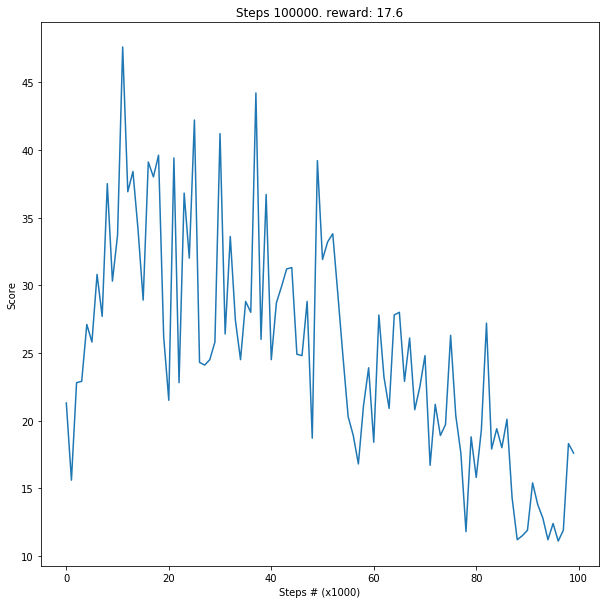

Process Process-141:
Process Process-144:
Process Process-142:
Process Process-143:
Process Process-140:
Process Process-137:
Process Process-139:
Process Process-138:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(

In [48]:
hyperameters = {
    'hidden_size': 64,
    'learning_rate':3e-4,
    'num_step_td_update': 5,
    'max_steps':100000,
    'gamma': 0.99
}
model = actor_critic( hyperameters, 345)

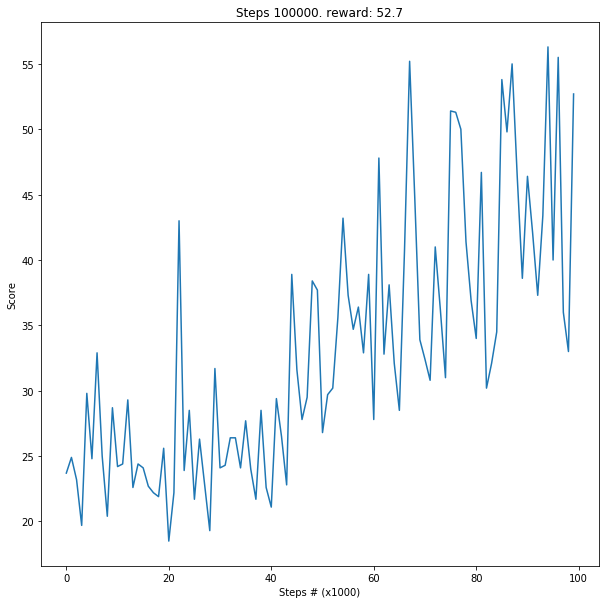

In [58]:
hyperameters = {
    'hidden_size': 128,
    'hidden_size_2': 64,
    'learning_rate':1e-5,
    'num_step_td_update': 2,
    'max_steps':100000,
    'gamma': 0.99
}
model_2 = actor_critic(hyperameters, 500)

## Seeing our learned policy in action

Let's watch our agent!

In [ ]:
env_1 = gym.make('CartPole-v1')
state = env_1.reset()
for t in range(2000):
    dist, _ = model(torch.from_numpy(state).float().to(device))
    action = dist.sample()
    env_1.render()
    state, reward, done, _ = env_1.step(action.item())
    if done:
        break
del env_1

# Let's try another environment - LunarLander-v2

In [ ]:
env = gym.make('LunarLander-v2')
print('Environment:', 'LunarLander-v2')
print('\t','action space:', env.action_space)
print('\t','observation space:', env.observation_space)

In [ ]:
from utils.multiprocessing_env import SubprocVecEnv

num_envs = 8
env_name = 'LunarLander-v2'
def make_env(seed, rank):
    def _thunk():
        env = gym.make(env_name)
        env.seed(seed+rank)
        return env

    return _thunk

Different environments can be learned with the same algorithm. Only the hyper-parameters usually have to be tuned for optimal performance. Among the important hyperparameters, one should look at the **learning rate**, **the discount factor** and the **number of epochs**.

For instance if the learning is too slow, you can try increasing the learning rate but that might also create additional instabilities in the learning. To increase stability, you can you can try to reduce the training discount factor but if you set it to a too low value, you might not be optimizing the right objective and learning can therefore not be optimal.

In [ ]:
hyperameters = {
    'hidden_size_1': 128,
    'hidden_size_2': 64,
    'learning_rate':1e-4,
    'num_step_td_update': 5,
    'max_steps':15000,
    'gamma': 0.9
}
model_2 = actor_critic(hyperameters, 111)

## Seeing our learned policy in action

Let's watch our agent!

In [ ]:
env_1 = gym.make('LunarLander-v2')
state = env_1.reset()
for t in range(2000):
    dist, _ = model_2(torch.from_numpy(state).float().to(device))
    action = dist.sample()
    env_1.render()
    state, reward, done, _ = env_1.step(action.item())
    if done:
        break
del env_1